Missing value per kolom:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Jumlah data duplikat: 0
Fitting 5 folds for each of 48 candidates, totalling 240 fits

=== Hasil Evaluasi Model Random Forest dengan Pipeline ===
Akurasi: 0.8638743455497382

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86        98
           1       0.83      0.91      0.87        93

    accuracy                           0.86       191
   macro avg       0.87      0.87      0.86       191
weighted avg       0.87      0.86      0.86       191



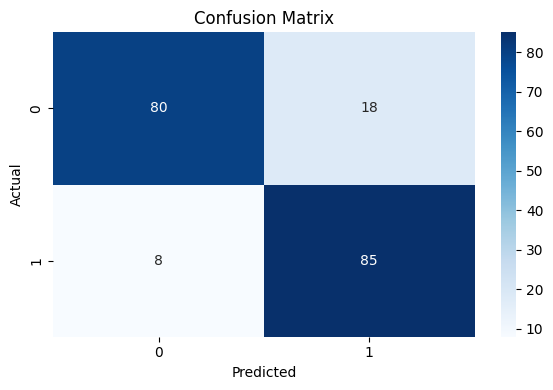

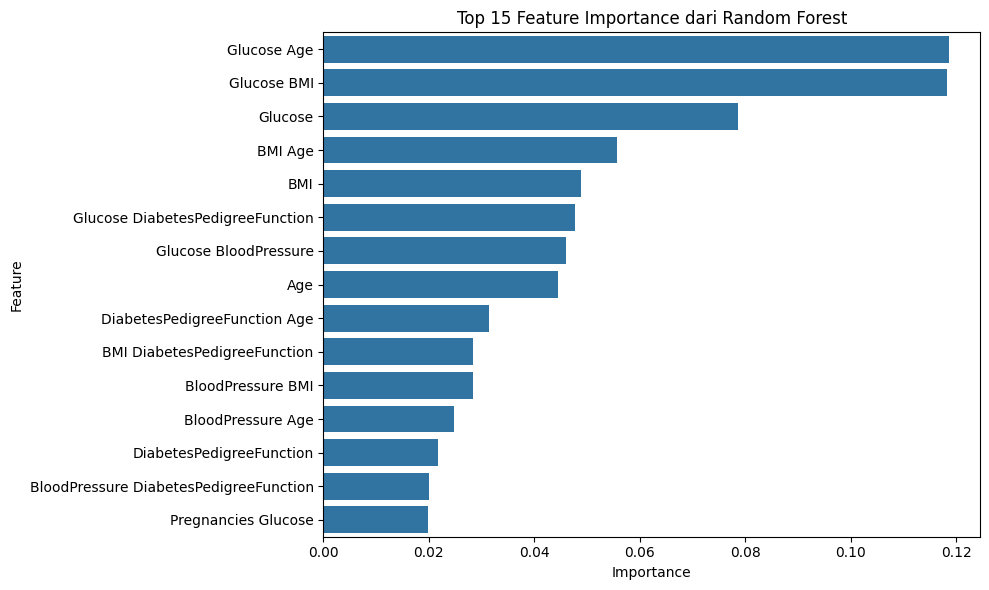

✅ Pipeline berhasil disimpan ke 'simpan_model/model_pipeline.joblib'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.combine import SMOTETomek
from joblib import dump

# Load dataset
df = pd.read_csv("diabetes.csv")
print("Missing value per kolom:\n", df.isnull().sum())
print("Jumlah data duplikat:", df.duplicated().sum())

# Fitur dan label
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Penyeimbangan data terlebih dahulu (sebelum split)
smote = SMOTETomek(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Pipeline preprocessing + model
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Parameter grid (khusus untuk model di dalam pipeline)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 4],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2'],
    'model__class_weight': ['balanced']
}

# Cross-validation dan GridSearch
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Evaluasi
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

print("\n=== Hasil Evaluasi Model Random Forest dengan Pipeline ===")
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature Importance (Top 15)
# Ambil fitur hasil PolynomialFeatures
poly_feat_names = grid_search.best_estimator_.named_steps['poly'].get_feature_names_out(X.columns)
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_

feature_importance = pd.Series(importances, index=poly_feat_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.values[:15], y=feature_importance.index[:15])
plt.title("Top 15 Feature Importance dari Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Simpan pipeline
dump(best_pipeline, './../simpan_model/model_pipeline.joblib')
print("✅ Pipeline berhasil disimpan ke 'simpan_model/model_pipeline.joblib'")